# Gradient recovery and inversion under Secure Aggregation via gradient supression attack.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from federated_learning import FL_server, FL_SGD_client_classification, setup_users_classification
from gradient_inversion import gradient_inversion, check_gradient, plot
from utility import lr_schlr, clone_list_tensors

# Evading Secure Aggregation via gradient supression

## Setup

In [2]:
num_users = 10
batch_size = 16
local_training_set_size = 32

dataset, _ = tf.keras.datasets.mnist.load_data()
# if including the last layer's bias term in the architecture
with_last_layer_bias_term = True
input_shape = (28, 28, 1)
num_classes = 10
# Pick target user for gradient-suppression-based SA evasion
target_user = 0

# Model
def make_model(input_shape, num_classes, with_last_layer_bias_term):
    xin = tf.keras.layers.Input(input_shape)
    
    x = tf.keras.layers.Conv2D(32, 3, 1, activation='relu')(xin)
    x = tf.keras.layers.Conv2D(64, 3, 2, activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, 2, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_classes, use_bias=with_last_layer_bias_term)(x)
    y = tf.keras.layers.Softmax()(x)
    
    model = tf.keras.Model(inputs=xin, outputs=y)
    return model

## Setup users FL

In [3]:
def parse_mnist(x):
    x = (x / (255/2) - 1)
    x = x[:,:,:,np.newaxis]
    return x

model = make_model(input_shape, num_classes, with_last_layer_bias_term)
users = setup_users_classification(
    FL_SGD_client_classification,
    num_users,
    model,
    dataset,
    batch_size,
    local_training_set_size,
    parse_mnist
)

## Setup Gradient suppression

In [4]:
from suppressing_nets import zero_all_network, zero_kernel_i

def kill_last_two_layers_cnn(model):
    var = clone_list_tensors(model.trainable_variables)
    var = zero_kernel_i(var, -1)
    var = zero_kernel_i(var, -2)
    var = zero_kernel_i(var, -3)
    var = zero_kernel_i(var, -4)
    return var

suppressing_technique = kill_last_two_layers_cnn

## Run FL for one round

In [5]:
FL = FL_server(users, model, suppressing_technique, target=target_user)
# Run FL
FL.models_distribution()
# Get secure aggregation output
agg = FL.SA()

# check if gradient has been recovered
print("Checking results...")
recovered_gradient = check_gradient(agg, users[target_user].gradient)
print(f'Recovered gradient: {np.round(recovered_gradient*100, 3)}%')

Sending honest parameters to user 0
Sending tampered parameters to user 1
Sending tampered parameters to user 2
Sending tampered parameters to user 3
Sending tampered parameters to user 4
Sending tampered parameters to user 5
Sending tampered parameters to user 6
Sending tampered parameters to user 7
Sending tampered parameters to user 8
Sending tampered parameters to user 9
End model distribution

Receiving and aggregating model update from user 0
Receiving and aggregating model update from user 1
Receiving and aggregating model update from user 2
Receiving and aggregating model update from user 3
Receiving and aggregating model update from user 4
Receiving and aggregating model update from user 5
Receiving and aggregating model update from user 6
Receiving and aggregating model update from user 7
Receiving and aggregating model update from user 8
Receiving and aggregating model update from user 9
End aggregation

Checking results...
	layer: 0 with shape (288,) recovered?: True
	layer

# Invert recovered gradient

In [6]:
num_iter = 1800
without_last_bias = with_last_layer_bias_term
rng_seed = None
w_reg = 1 / 25000
init_lr = .1
setps_lrs = [1000, 1250, 1500]
    
opt = tf.keras.optimizers.Adam(lr_schlr(init_lr, setps_lrs))

## Setup gradient inversion

In [7]:
inv_g, _, logs = gradient_inversion(
    model,
    agg,
    opt,
    num_iter,
    batch_size,
    input_shape,
    num_classes, 
    without_last_bias,
    w_reg,
    rng_seed
)

Running inversion...
	[0%] loss: 0.9864261746406555
	[10%] loss: 0.06305762380361557
	[20%] loss: 0.04762967675924301
	[30%] loss: 0.04414226487278938
	[40%] loss: 0.04669921100139618
	[50%] loss: 0.04307415336370468
	[Scaling learning rate: 0.01]
	[60%] loss: 0.030899621546268463
	[Scaling learning rate: 0.001]
	[70%] loss: 0.029516812413930893
	[80%] loss: 0.02707313746213913
	[Scaling learning rate: 0.0001]
	[90%] loss: 0.027526648715138435


## Plot inverted gradient (unsorted)

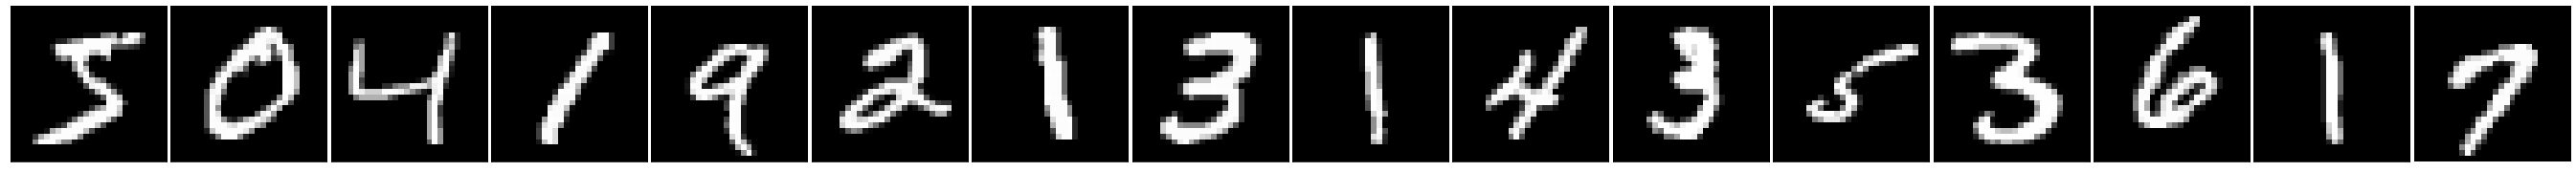

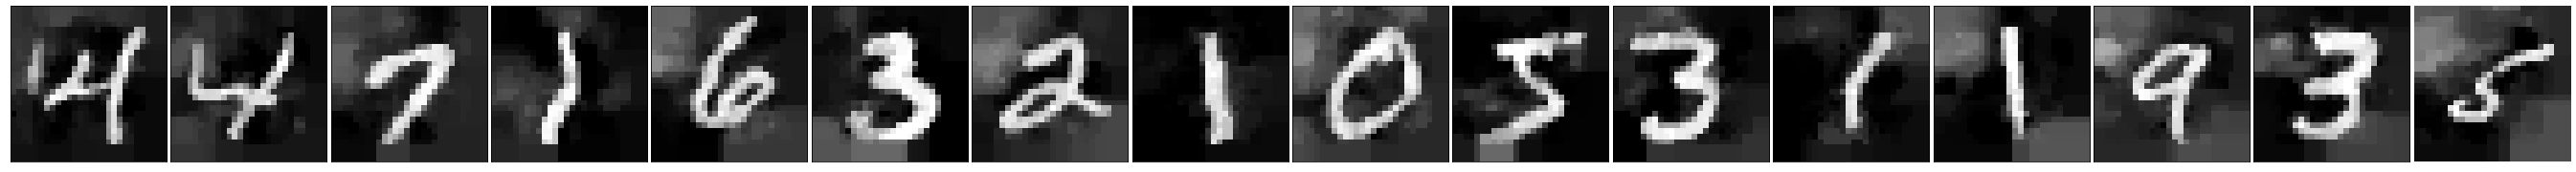

In [8]:
gt = users[target_user].data[0][:,:,:,0]
recovered = inv_g[:,:,:,0]

cmap = "gray"
# Ground truth 
fig, ax = plot(gt, cmap=cmap);
# Recovered
fig, ax = plot(recovered, cmap=cmap);